In [1]:
# import numpy as np
# import matplotlib.pyplot as plt

import math



In [2]:
# def f(x):
#     return 3*x**2 - 4*x + 5

In [3]:
# xs = np.arange(-5,5,0.25)
# ys = f(xs)
# plt.plot(xs,ys)
# plt.figure(figsize=(5,5))

In [4]:
# h = 0.000001
# x = 2/3
# (f(x+h)- f(x))/h

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [6]:
class Value:
    def __init__(self,data, _children = (), _op = (), label = '' ):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad +=  out.grad
            other.grad +=  out.grad
        
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other

    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only support int/float as power for now"
        out = Value(self.data**other, (self,), label = f"**{other}")

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __neg__(self):
        return -1 * self
    
    def __sub__(self,other):
        return self + (-other)
    
    def __rsub__(self,other):
        return other + (-self)

    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def  __rtruediv__(self,other):
        return other * self**-1


    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self,), 'exp')

        def _backward():
            self.grad += t * out.grad
        out._backward  = _backward
        return out
    
    def relu(self):
        t = 0.0 if self.data < 0 else self.data
        out = Value(t, (self,),'relu')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        
        return out


    def tanh(self):
        x = self.data
        t  = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        visited = set()
        topo = []
        def build_topo(V):
            if V not in visited:
                visited.add(V)
                for node in V._prev:
                    build_topo(node)
                topo.append(V)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        





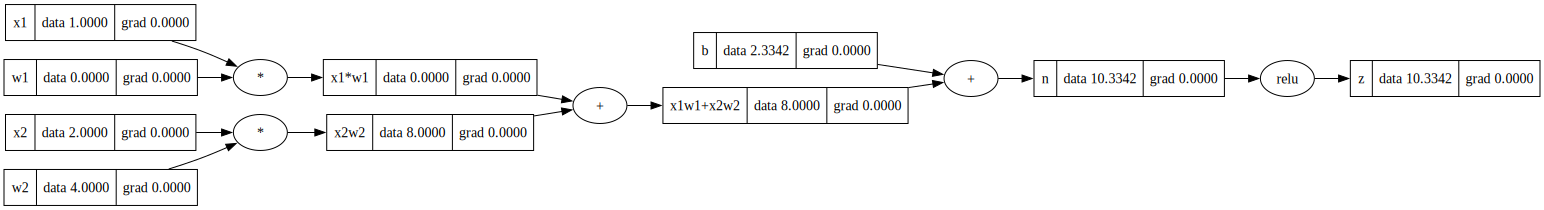

In [7]:
x1 = Value(1,label = 'x1')
w1 = Value(0, label = 'w1')
x2 = Value( 2, label = 'x2')
w2 = Value( 4, label = 'w2')
b = Value(2.33423002, label = 'b')
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1+x2w2'

n = x1w1x2w2 + b; n .label = 'n'
z = n.relu(); z.label = 'z'
draw_dot(z)


In [8]:
import torch
def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    # draw_dot(y)
    xmg, ymg = x, y


    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y
    

    assert ymg.data == ypt.data.item(), "output doesn't match"
    print(xmg.grad,xpt.grad.item())
    assert xmg.grad == xpt.grad.item(), "gradients doesn't match"
test_sanity_check()

46.0 46.0


In [39]:
import random

class Module:
    def zero_grad(self):
      for paramter in self.parameters():
         paramter.grad = 0
    
    def parameters(self):
        return []
         

class Neuron(Module):
  def __init__(self,n, nonlin = True ):
    self.w = [Value(random.uniform(-0.1,0.1)) for _ in range(n)]
    self.b = Value(0)
    self.nonlin = nonlin
  
  def parameters(self):
    return  self.w + [self.b]
  
  def __call__(self,x):
    act = sum( (xi*wi for xi,wi in zip(self.w,x)), self.b)
    out = act.relu() if self.nonlin else act
    return out

  def __repr__(self):
     return f'{"Relu " if self.nonlin else "linear "}Neuron({len(self.w)})'
  
class Layer(Module):
  def __init__(self,nin, nout, **kwargs):
      self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]
    
  def parameters(self):
      return [ parameter for neuron in self.neurons for parameter in neuron.parameters()]
    
  def __call__(self,x):
      outs = [neuron(x) for neuron in self.neurons]
      return outs[0] if len(outs) == 1 else outs
  
  def __repr__(self):
     return f'Layer of ({[str(neuron) for neuron in self.neurons]})'
    
  
class MLP(Module):
  def __init__(self, nin, nout, nonlin = True):
    sz = [nin] + nout
    self.layers = [Layer(sz[i],sz[i+1],nonlin = (i != len(nout)-1)) for i in range(len(nout))]
  
  def parameters(self):
    return [parameter for layer in self.layers for parameter in layer.parameters() ]
  
  def __call__(self,x):
      for layer in self.layers:
        x = layer(x)
      return x
  
  def __repr__(self):
     return f'MLP ( {[str(layer) for layer in self.layers]} )'
      

In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt

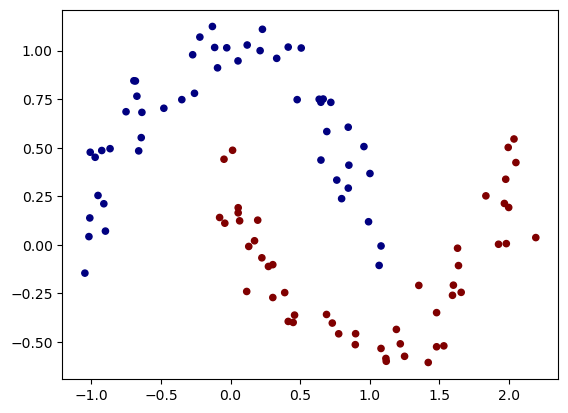

In [11]:
from sklearn.datasets import make_moons
np.random.seed = 42
X,y = make_moons(100,noise = 0.1)
y = y*2 - 1
plt.scatter(X[:,0],X[:,1],c=y, s = 20,cmap = 'jet')

In [78]:
model = MLP(2,[16,16,1])
print(model)


MLP ( ["Layer of (['Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)', 'Relu Neuron(2)'])", "Layer of (['Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)', 'Relu Neuron(16)'])", "Layer of (['linear Neuron(16)'])"] )


In [79]:
def loss(batch_size = None):
    #data loader
    if batch_size:
        indices = np.random.permutation(len(X))[:batch_size]
        Xb,yb = X[indices],y[indices]
    else:
        Xb,yb = X,y

    inputs = [list(map(Value, xi)) for xi in Xb]
    scores = list(map(model,inputs))

    losses = [ ( 1 + -yi*scorei).relu() for yi,scorei in zip(yb,scores)]
    #L2 regression loss
    alpha = 1e-4
    # reg_loss = sum(p*p for p in model.parameters())
    reg_loss = 0

    total_loss = sum(losses) + alpha*reg_loss
    accuracies = [(yi > 0) == (scorei.data > 0) for yi,scorei in zip(yb,scores)]

    return total_loss, sum(accuracies)/len(accuracies)
print(loss())

(Value(data = 99.98463758658458), 0.42)


After 10 steps, loss : 99.31156787266286, accuracy : 73.0 %
After 20 steps, loss : 36.28053892201196, accuracy : 83.0 %
After 30 steps, loss : 27.77620789999052, accuracy : 88.0 %
After 40 steps, loss : 26.73464685339158, accuracy : 87.0 %
After 50 steps, loss : 24.87213012922235, accuracy : 90.0 %
After 60 steps, loss : 24.006763700108976, accuracy : 91.0 %
After 70 steps, loss : 22.767266501399128, accuracy : 91.0 %
After 80 steps, loss : 22.101047444813453, accuracy : 91.0 %
After 90 steps, loss : 21.409138023860006, accuracy : 91.0 %
After 100 steps, loss : 20.83998737505577, accuracy : 91.0 %
After 110 steps, loss : 19.4636623459164, accuracy : 91.0 %
After 120 steps, loss : 20.733078675948875, accuracy : 92.0 %
After 130 steps, loss : 16.500124928571346, accuracy : 92.0 %
After 140 steps, loss : 10.834202105113496, accuracy : 96.0 %
After 150 steps, loss : 26.963529525542842, accuracy : 90.0 %
After 160 steps, loss : 17.124179805607124, accuracy : 93.0 %
After 170 steps, loss : 1

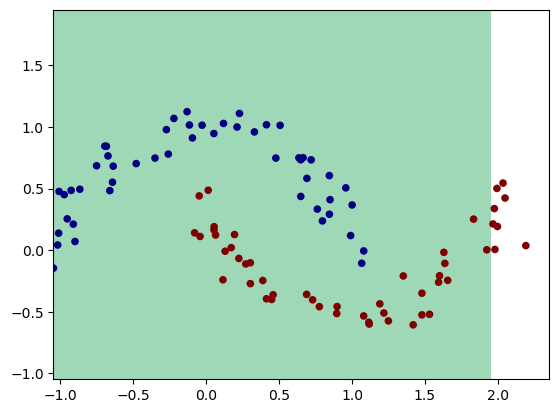

In [ ]:
for k in range(300):
    
    total_loss,accuracy = loss()
    
    model.zero_grad()
    total_loss.backward()
    # print(f'{k}: {max(abs(p.data) for p in model.parameters()), min(abs(p.data) for p in model.parameters())}')

    # gradient descent step
    # theta = max(0.01,1.0 - 0.9*k/100)
    theta = 0.01
    for p in model.parameters():
        
        p.data = p.data - theta*p.grad
    if (k+1) % 10 == 0:
        print(f'After {k+1} steps, loss : {total_loss.data}, accuracy : {accuracy*100} %')

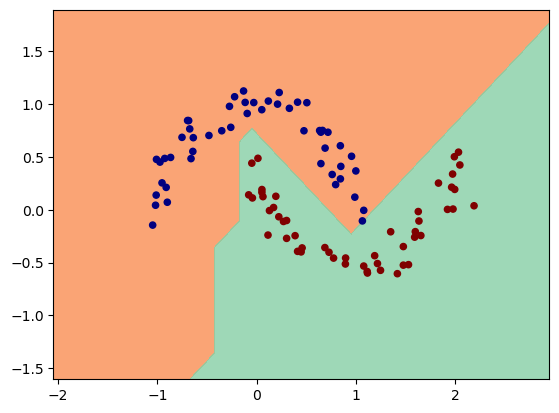

In [99]:
def plot():
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1  , X[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min,x_max,0.25),np.arange(y_min,y_max,0.25))
    Xmesh = np.c_[xx.ravel(),yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model,inputs))
    Z = np.array([score.data > 0 for score in scores])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx,yy,Z,cmap = plt.cm.Spectral,alpha = 0.8)
    plt.scatter(X[:,0],X[:,1],c=y,s = 20,cmap = 'jet')
plot()